In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import os
from PIL import Image
from sklearn import svm, linear_model, ensemble, neighbors, tree

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as pl
import cv2 as cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import shuffle
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


from tensorflow.keras.utils import normalize, to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input,Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense,BatchNormalization

from keras.models import Sequential, Model
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
image_directory='dataset/'
no_tumor_images=os.listdir(image_directory+ 'no/')
yes_tumor_images=os.listdir(image_directory+ 'yes/')

print('No Tumor: ', len(no_tumor_images))
print('Tumor: ',len(yes_tumor_images))

No Tumor:  1500
Tumor:  1501


In [4]:
dataset=[]
label=[]

INPUT_SIZE=224

In [5]:
for i , image_name in enumerate(no_tumor_images):
    if(image_name.split('.')[1]=='jpg'):
        image=cv2.imread(image_directory+'no/'+image_name)
        image=Image.fromarray(image,'RGB')
        image=image.resize((INPUT_SIZE,INPUT_SIZE))
        dataset.append(np.array(image))
        label.append(0)

In [6]:
for i , image_name in enumerate(yes_tumor_images):
    if(image_name.split('.')[1]=='jpg'):
        image=cv2.imread(image_directory+'yes/'+image_name)
        image=Image.fromarray(image, 'RGB')
        image=image.resize((INPUT_SIZE,INPUT_SIZE))
        dataset.append(np.array(image))
        label.append(1)

In [7]:
dataset = np.array(dataset)
label = np.array(label)

In [8]:
# Data generators
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=90,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2)
train_generator=train_datagen.flow_from_directory('dataset/',
                                                  target_size=(224,224), color_mode='rgb', shuffle=True,
                                                  subset='training', batch_size=32, class_mode='categorical')

test_generator = test_datagen.flow_from_directory('dataset/',
                                                  target_size=(224,224), color_mode='rgb', shuffle=True,
                                                  subset='validation', batch_size=16, class_mode='categorical')

Found 3061 images belonging to 3 classes.
Found 612 images belonging to 3 classes.


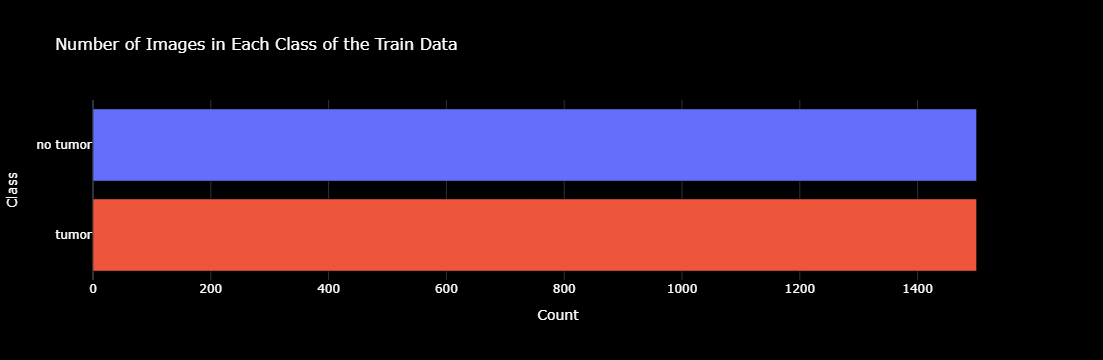

In [9]:
import numpy as np
import pandas as pd
import plotly.express as px

# Count the number of images in each class
class_counts = np.bincount(label)
class_names = ['no tumor', 'tumor']

# Create a DataFrame with class names and counts
train_df = pd.DataFrame({'Class': class_names, 'Count': class_counts})

# Create a histogram for the train labels using Plotly Express
fig = px.bar(train_df, y='Class', x='Count', color='Class', template='plotly_dark',
             title='\nNumber of Images in Each Class of the Train Data', orientation='h')

# Update hover template to display count and label
fig.update_traces(hovertemplate='Count: %{x}<br>Class: %{y}')

# Update layout with custom styles
fig.update_layout(title_font=dict(color='white'),
                  legend=dict(font=dict(color='white')),
                  paper_bgcolor='black',  # Set black paper background
                  plot_bgcolor='rgba(0, 0, 0, 0)',  # Set transparent plot background
                  font=dict(color='white'),  # Set font color to white
                  title={'font': {'size': 16}},  # Decrease title font size
                  showlegend=False)  # Hide legend

# Set the template style to 'plotly_dark'
fig.update_layout(template='plotly_dark')

# Show the plot
fig.show()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size=0.2, random_state=0)

In [11]:
X_train = X_train/255.0
X_test = X_test/255.0

In [12]:
print('X_train Shape: ', X_train.shape)
print('X_test Shape: ', X_test.shape)
print('y_train Shape: ', y_train.shape)
print('y_test Shape: ', y_test.shape)

X_train Shape:  (2400, 224, 224, 3)
X_test Shape:  (600, 224, 224, 3)
y_train Shape:  (2400,)
y_test Shape:  (600,)


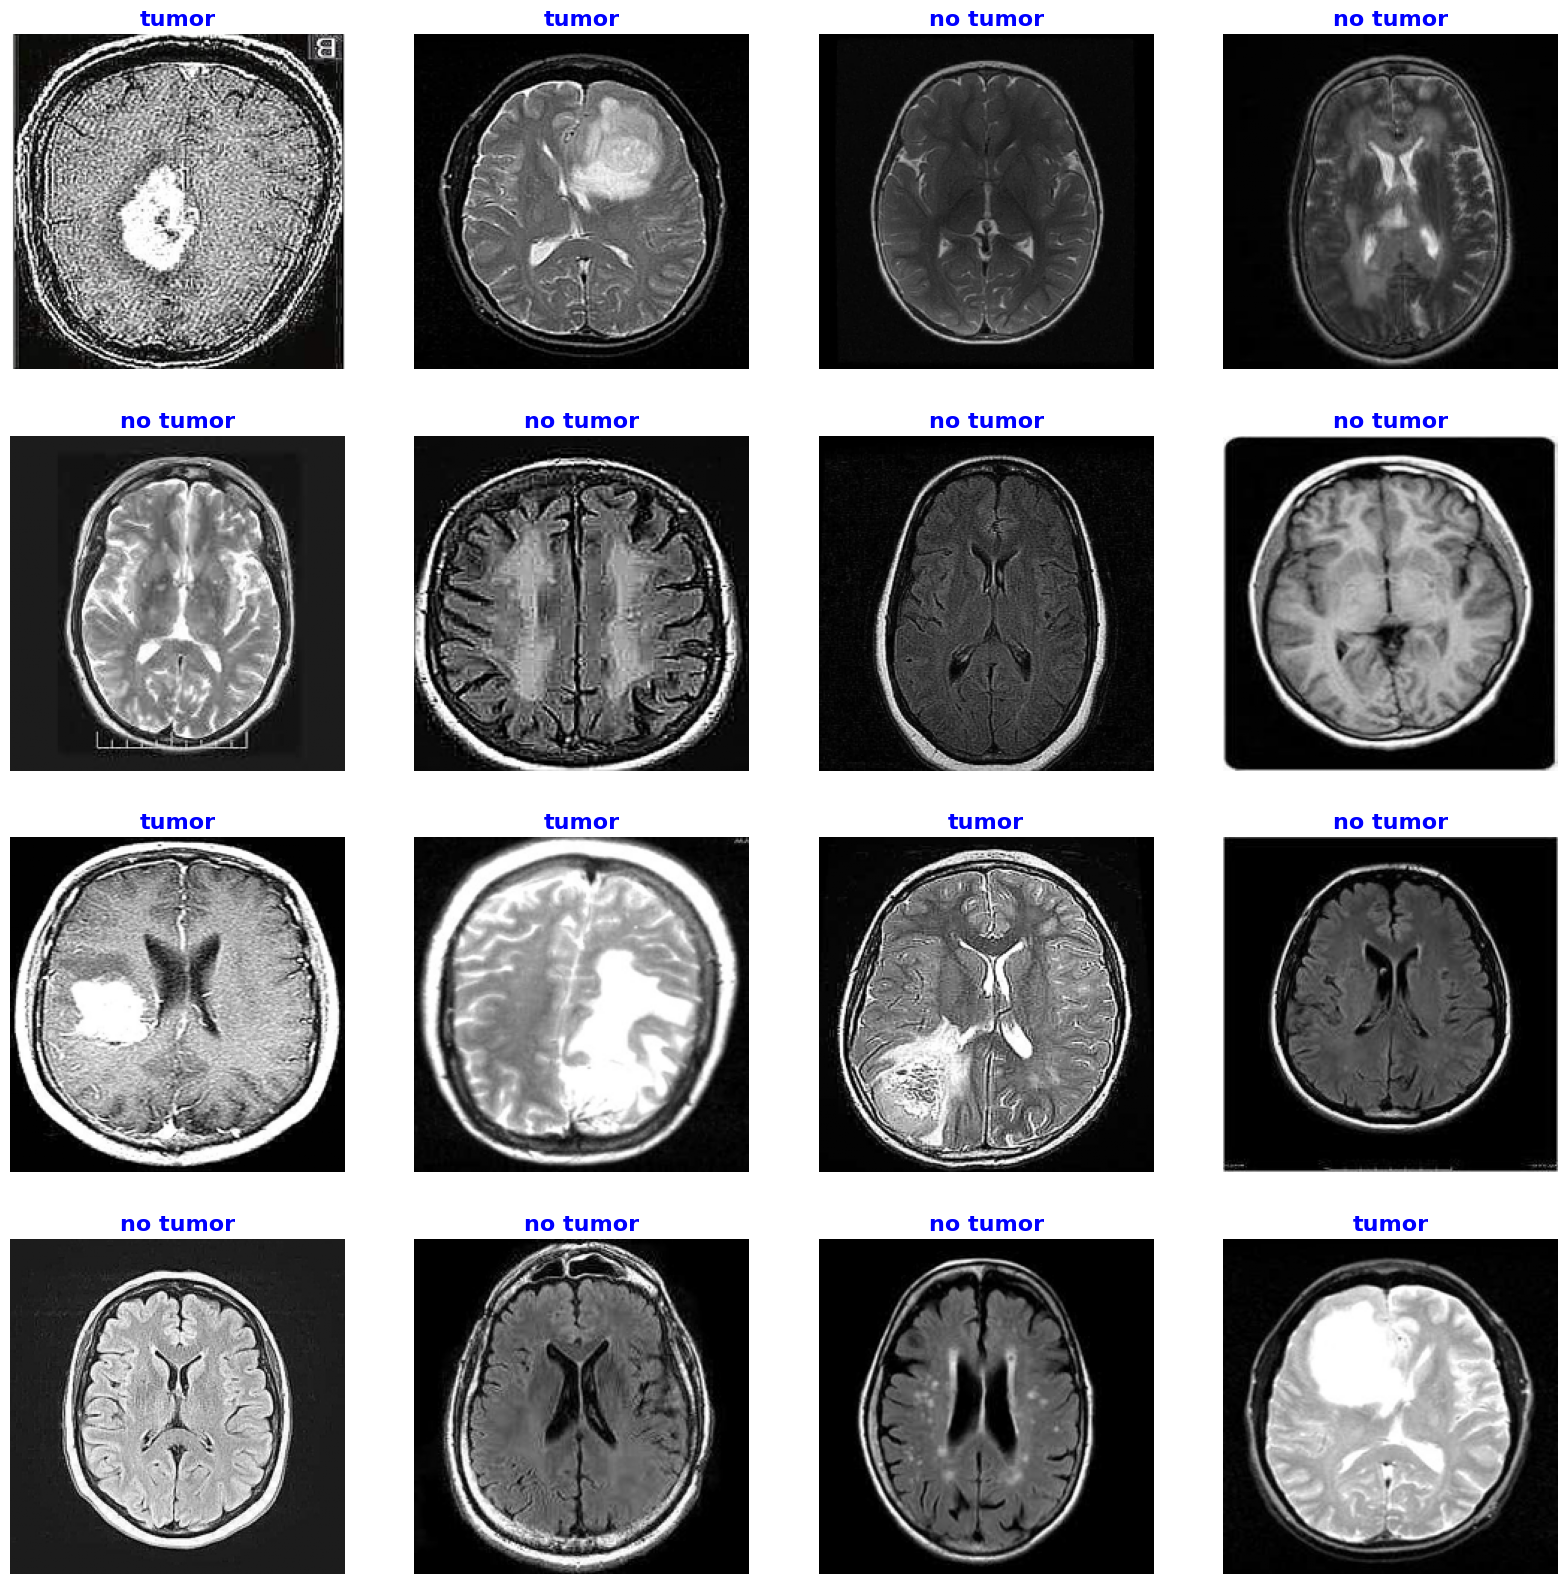

In [13]:
import matplotlib.pyplot as plt

# Plotting the images
plt.figure(figsize=(20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(X_train[i])
    plt.title(class_names[y_train[i]], color='blue', fontsize=16, fontweight='bold')
    plt.axis("off")
plt.show()

In [14]:
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Convert target values to one-hot vectors
y_train_encoded = to_categorical(y_train, num_classes=2)
y_test_encoded = to_categorical(y_test, num_classes=2)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam

# Define the input size
INPUT_SIZE = 224  # You can adjust this to the size required

# Load the pre-trained Xception model and exclude its top layers
base_model = Xception(weights='imagenet', include_top=False, input_shape=(INPUT_SIZE, INPUT_SIZE, 3))

# Freeze the base model layers to prevent them from being trained
base_model.trainable = False

# Create a new Sequential model and add the base model
model = Sequential()
model.add(base_model)

# Add a global average pooling layer to reduce the tensor shape
model.add(GlobalAveragePooling2D())

# Add a fully connected layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Add the output layer with softmax activation for classification
model.add(Dense(2, activation='softmax'))  # Adjust the number of neurons according to your number of classes

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 7, 7, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,992,746 (80.08 MB)

 Trainable params: 131,266 (512.76 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
# Stop training if loss doesn't keep decreasing.
model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=10, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=6, verbose=True)

history_1 = model.fit(X_train, y_train_encoded, batch_size=16, epochs=5, verbose=1, shuffle=False ,
                     validation_data=(X_test, y_test_encoded), callbacks=[model_es, model_rlr])

In [17]:
# Make predictions softmax
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)  # Get the index of the maximum value

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Val Accuracy = %.2f' % accuracy)

19/19 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step
Val Accuracy = 0.96


In [1]:
model.save("trained_model_mri.keras")
model.save("trained_model_mri.h5")

NameError: name 'model' is not defined

In [18]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.model_selection import train_test_split

print("Classification Report:\n",classification_report(y_test,y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.97       343
           1       0.94      0.98      0.96       257

    accuracy                           0.96       600
   macro avg       0.96      0.96      0.96       600
weighted avg       0.96      0.96      0.96       600



In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.colors
import seaborn as sns

colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

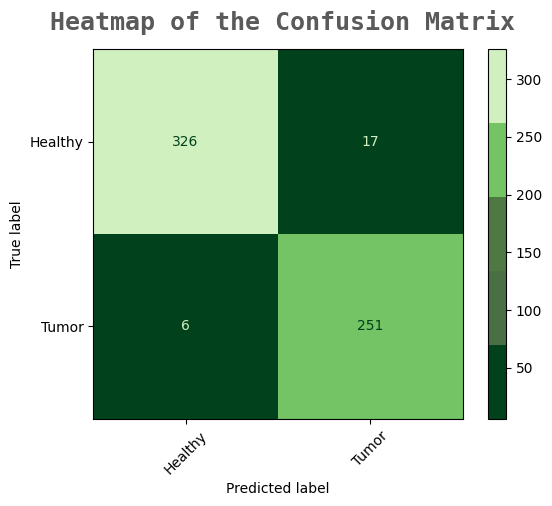

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.colors
import seaborn as sns

labels = ['Healthy','Tumor']

colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

# Define the custom color map
custom_colors = ['#01411C', '#4B6F44', '#4F7942', '#74C365', '#D0F0C0']
custom_cmap = matplotlib.colors.ListedColormap(custom_colors)

# Calculate confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)

# Create a display object with the custom color map
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['Healthy', 'Tumor'])

# Plot the confusion matrix
fig, ax = plt.subplots()
disp.plot(cmap=custom_cmap, ax=ax)

# Set the title and axis labels
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.10,alpha=0.8)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show the plot
plt.show()

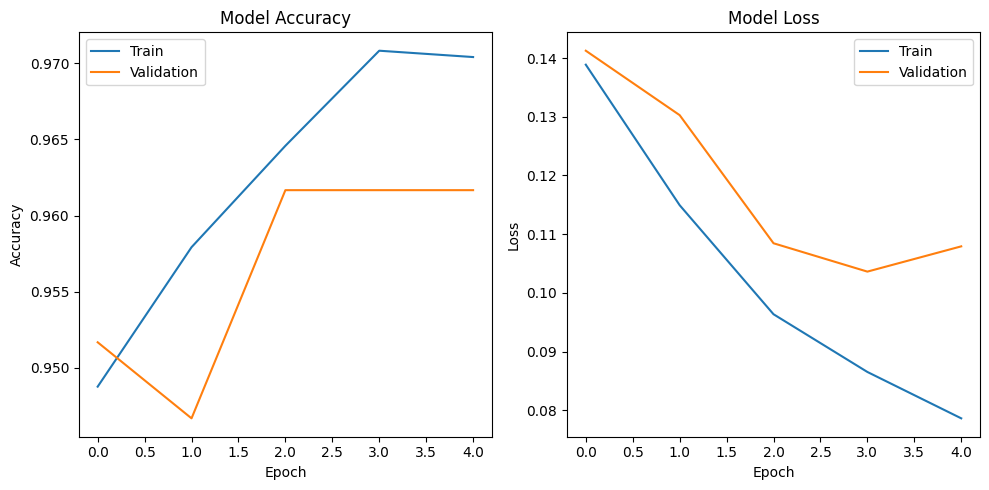

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot training and validation accuracy
ax[0].plot(history_1.history['accuracy'])
ax[0].plot(history_1.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training and validation loss
ax[1].plot(history_1.history['loss'])
ax[1].plot(history_1.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step


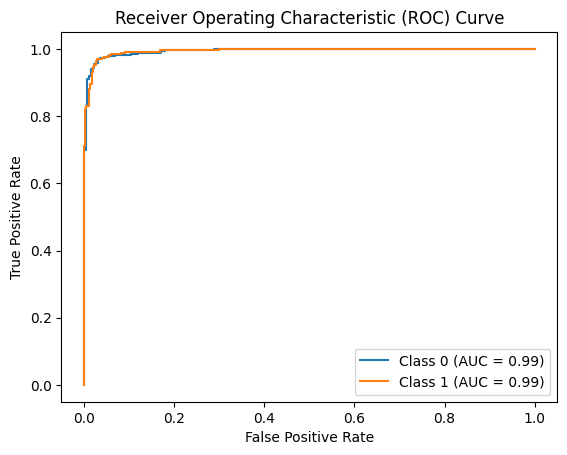

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np

# Compute predicted probabilities for each class
y_probs = model.predict(X_test)

# Ensure that the target labels Y_test are in a 2-dimensional format
if len(y_test.shape) == 1:
    Y_test = np.eye(len(np.unique(y_test)))[y_test.astype(int)]

# Compute the ROC curve and AUC score for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(Y_test.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_probs[:, i])
    roc_auc[i] = roc_auc_score(Y_test[:, i], y_probs[:, i])

# Plot the ROC curve for each class
plt.figure()
for i in range(Y_test.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Set the title and axis labels
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Show the plot
plt.show()

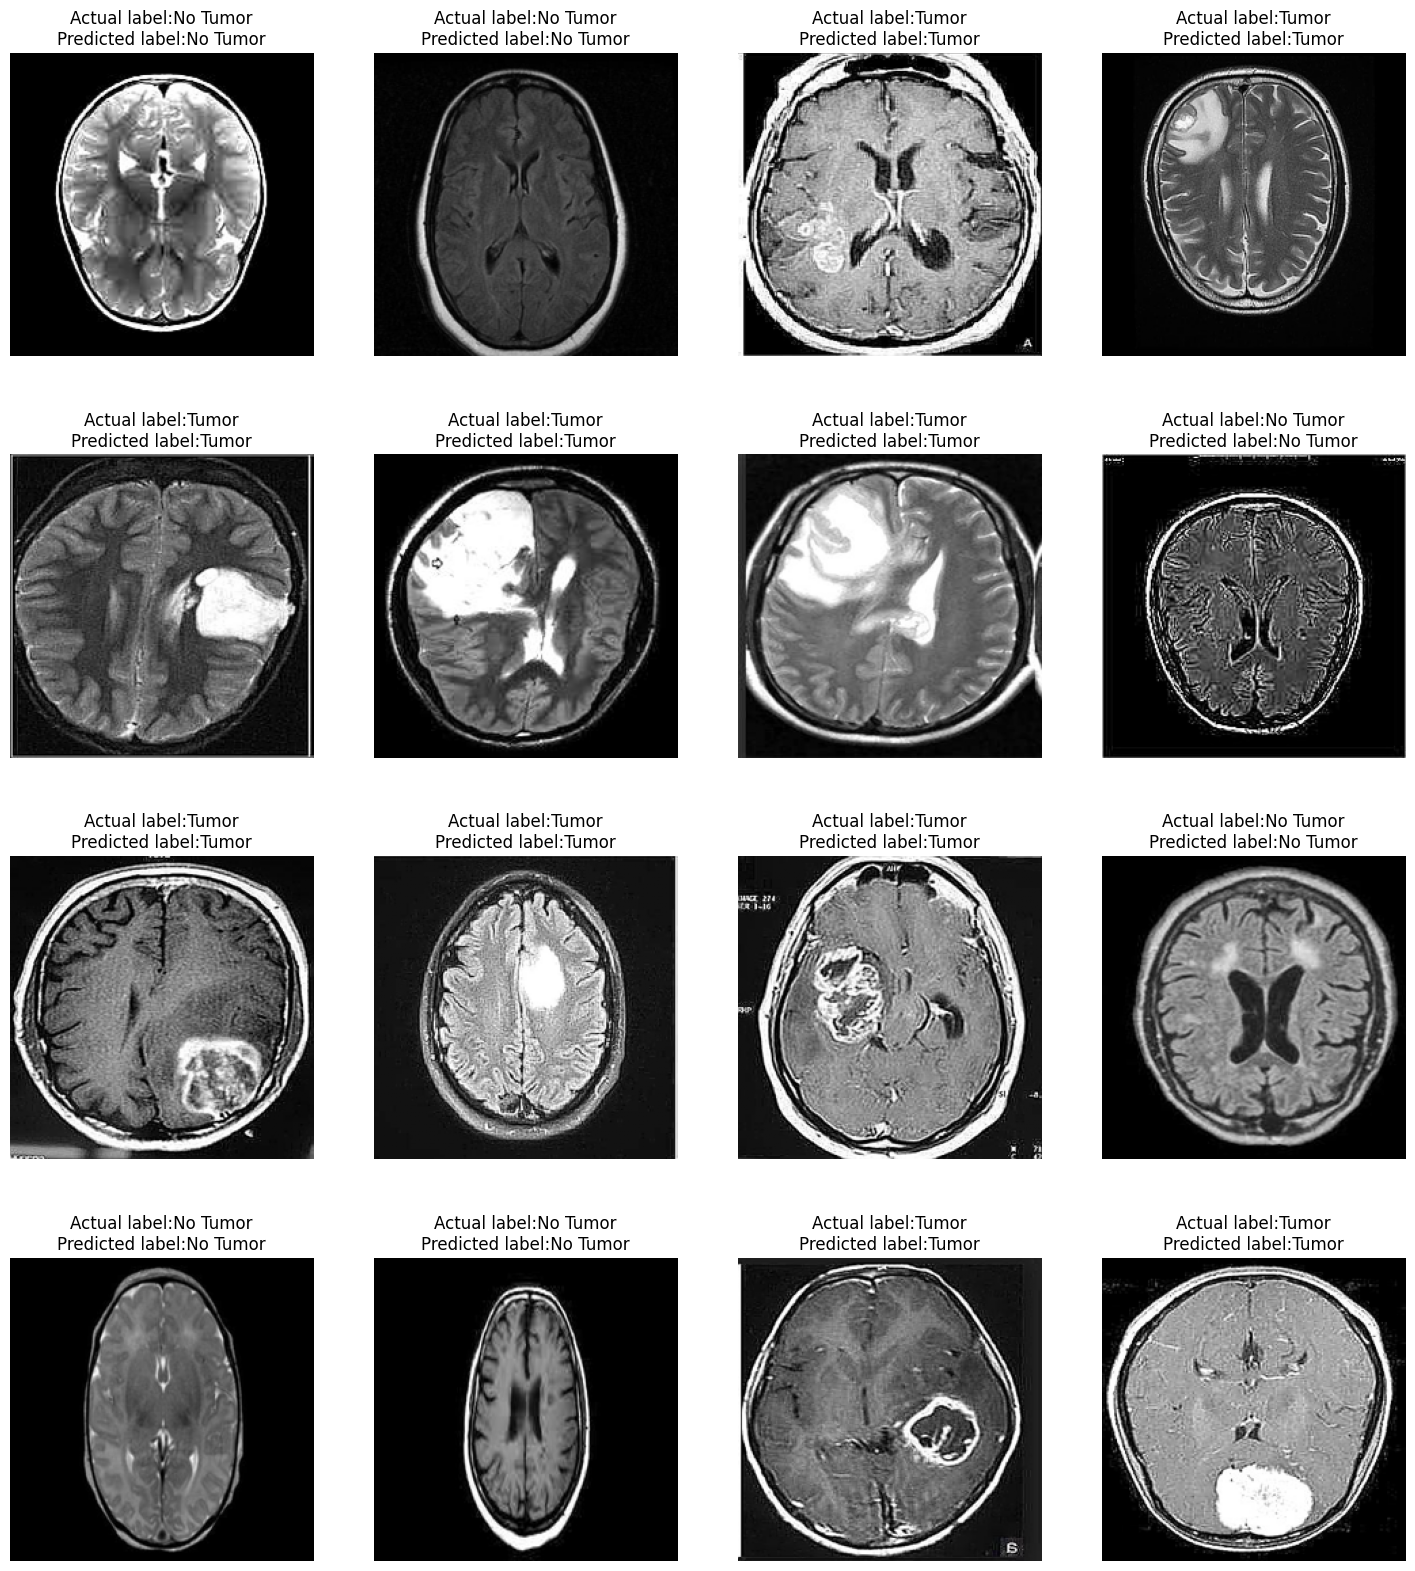

In [23]:
class_labels=["No Tumor","Tumor"]
plt.figure(figsize=(18,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(X_test[i])
    plt.title(f"Actual label:{class_labels[y_test[i]]}\nPredicted label:{class_labels[y_pred[i]]}",color = 'black')
    plt.axis("off")

In [67]:
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    
    # Define the class labels
    labels = ['Healthy Brain', 'Tumor Brain']
    
    plt.figure(figsize=(12, 12))
    plt.style.use('fivethirtyeight')
    
    # Load and preprocess the image
    img = Image.open(img_path)
    resized_img = img.resize((224, 224))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255

    # Make predictions
    predictions = model.predict(img)
    probs = list(predictions[0])
    
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt='%.2f')
    
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


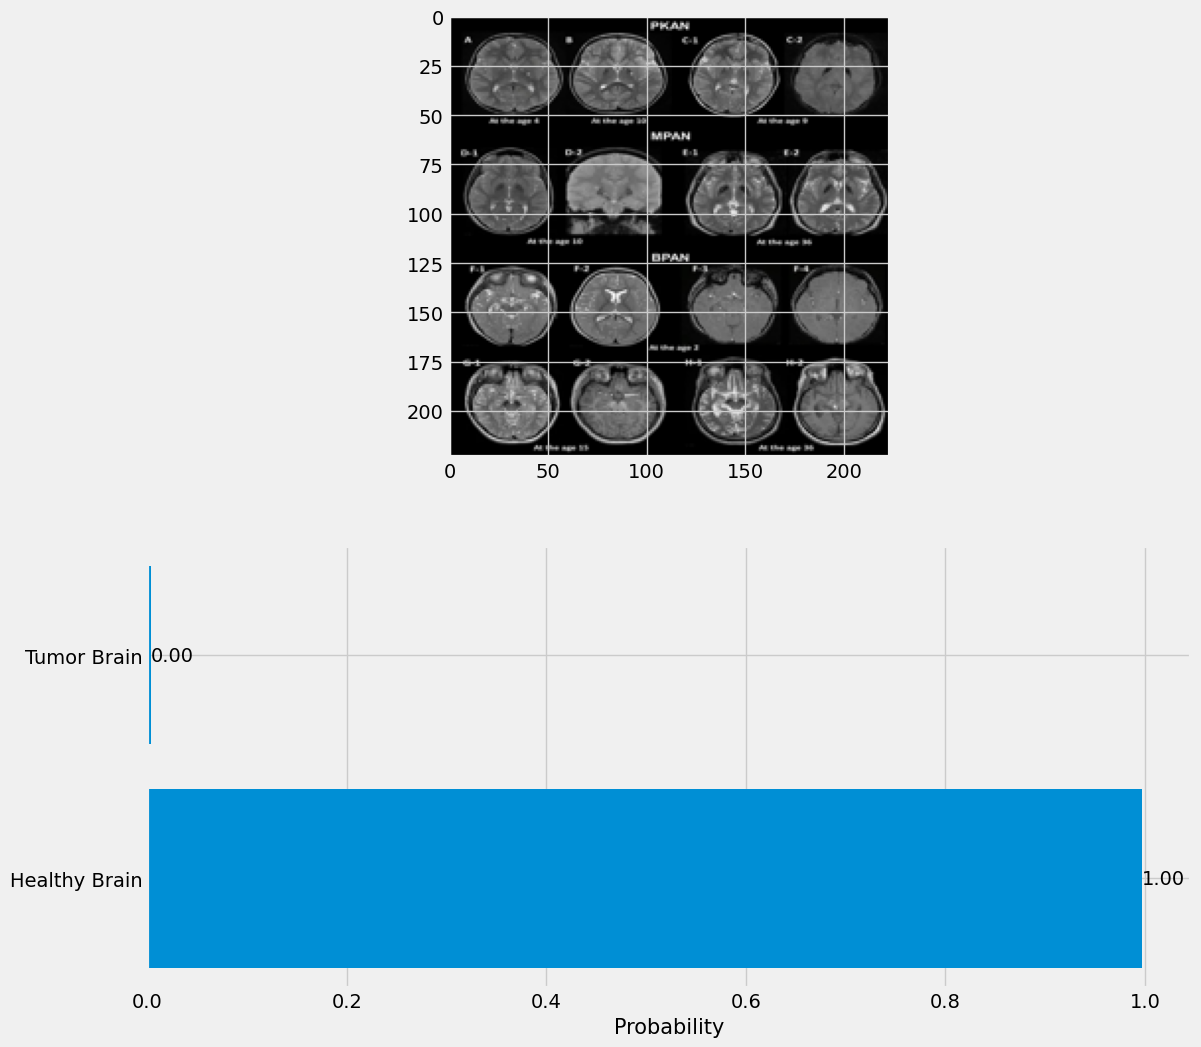

In [81]:
predict("scan.jpeg")